In [78]:
import pickle as pkl
from opt.mc_sim import *
import time
from common.variables import *
from opt.eval_policy import *

file_id = "msource_value_dic_12-23-2022-06-42-13.pkl"
filename = "output/" + file_id

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

# sourcingEnv2 = SourcingEnv(
#     lambda_arrival = model_params['mdp_env_params']['lambda'], # or 10
#     procurement_cost_vec = np.array(model_params['mdp_env_params']['procurement_cost_vec']),

#     supplier_lead_times_vec = np.array(model_params['mdp_env_params']['supplier_lead_times_vec']),
#     on_times = np.array(model_params['mdp_env_params']['on_times']), 
#     off_times = np.array(model_params['mdp_env_params']['off_times']),
#     fixed_costs = np.array(model_params['mdp_env_params']['fixed_costs'])) # np.array([np.Inf, np.Inf])) 

sourcingEnv2 = sourcingEnv

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

costs_array_labeled = []

model_params['mdp_env_params']



{'lambda': 5,
 'max_inven': 30,
 'action_size': 40,
 'discount_fac': 1.0,
 'procurement_cost_vec': [1.5, 0.5],
 'supplier_lead_times_vec': [0.019, 0.4],
 'on_times': [1, 1],
 'off_times': 'no_disrup',
 'fixed_costs': [0, 0]}

In [79]:
model_params.keys()

dict_keys(['algo_params', 'policy_params', 'mdp_env_params', 'eval_params', 'dual_index', 'lp_config', 'git_commit', 'branch_name'])

In [80]:
model_params['algo_params']

{'prob_epsilon': 1e-08,
 'periods': 30,
 'nested_mc_iters': 31,
 'mc_episodes': 32,
 'max_steps': 33,
 'explore_eps': 0.02,
 'debug_bool': 1,
 'fixed_learn_rate': 0.1}

In [81]:
model_params['eval_params']

{'safe_factor': 1.1,
 'n_visit_limit': 2,
 'sub_eval_periods': 30,
 'sub_nested_mc_iter': 30}

In [82]:
single_supplier_mean_costs = []
sing_supp_mean_cost = np.Inf
for s in range(sourcingEnv2.n_suppliers):

    kwargs = {"periods" : EVAL_PERIODS,
        "nested_mc_iters" : 100,
        "h_cost": model_params['policy_params']['h_cost'],
        "b_penalty" : model_params['policy_params']['b_penalty'],
        "supplier_index": s
    }

    single_supplier_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        use_tqdm = True,
        policy_callback = single_source_orderupto_policy,
        **kwargs)
    
    sing_supp_mean_cost_i = np.mean(single_supplier_costs)
    single_supplier_mean_costs.append(sing_supp_mean_cost_i)
    if sing_supp_mean_cost_i < sing_supp_mean_cost:
        single_supplier_costs_select = single_supplier_costs
        sing_supp_mean_cost = sing_supp_mean_cost_i

print(single_supplier_mean_costs)
print(np.min(single_supplier_mean_costs))

costs_array_labeled.extend([["SSN", c] for c in single_supplier_costs_select])

100%|██████████| 100/100 [00:03<00:00, 31.24it/s]

[1.7384217660327388, 1.0232209139559598]
1.0232209139559598


In [83]:
myopic_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = EVAL_PERIODS,
    nested_mc_iters = 5,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 2, # BIG_S,
    policy_callback=myopic2_policy,
    use_tqdm = True)

print(np.mean(myopic_costs))
print(np.median(np.array(myopic_costs)))
print(np.std(np.array(myopic_costs)))

costs_array_labeled.extend([["M2", c] for c in myopic_costs])

100%|██████████| 5/5 [00:07<00:00,  1.46s/it]

1.454160108069038
1.4595584160706843
0.03652477032480384


In [84]:
mc_avg_costs_ss = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = EVAL_PERIODS,
    nested_mc_iters = 100,
    policy_callback = ss_policy_fastest_supp_backlog,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_ss)))
print(np.median(np.array(mc_avg_costs_ss)))
print(np.std(np.array(mc_avg_costs_ss)))

costs_array_labeled.extend([["SS*", c] for c in mc_avg_costs_ss])

100%|██████████| 100/100 [00:03<00:00, 29.20it/s]

0.648104342733822
0.6433432869267979
0.027868343482270564


In [85]:
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = EVAL_PERIODS,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = BIG_S,
    policy_callback=dual_index_policy,
    use_tqdm = True
)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

costs_array_labeled.extend([["DI", c] for c in mc_avg_costs_di])

 10%|█         | 3/30 [00:02<00:24,  1.10it/s]/home/larkin/code/multi-sourcing-inventory/sim/policies.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 30/30 [00:32<00:00,  1.07s/it]

1.0555794152269515
1.0070245492124317
0.2703134419387186


In [86]:
import os

# check if lp file exists
lp_fname = "output/lp_sol_" + file_id
if os.path.isfile(lp_fname):
    kwargs_lp = {
        "value_dic": output_obj["state_value_dic"], 
        "periods": EVAL_PERIODS, 
        "periods_val_it": 1,
        "nested_mc_iters": 30,
        "discount_fac": DISCOUNT_FAC,
        "h_cost": output_obj['model_params']['policy_params']['h_cost'],
        "b_penalty": output_obj['model_params']['policy_params']['b_penalty'],
        "n_visit_lim": N_VISIT_LIM,
        "default_ss_policy": ss_policy_fastest_supp_backlog,
        "safe_factor": SAFE_FACTOR,
        "sub_eval_periods": SUB_EVAL_PERIODS,
        "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
        "max_stock": BIG_S,
        "approx_eval": True,
        "pol_dic": output_obj["pol_dic"],
        "env_filename": file_id
    }

    lp_mdp_costs = mc_with_policy(sourcingEnv, 
        policy_callback=lp_mdp_policy,
        use_tqdm = True,
        **kwargs_lp)

    costs_array_labeled.extend([["LP", c] for c in lp_mdp_costs])

100%|██████████| 30/30 [03:50<00:00,  7.67s/it]


In [87]:
kwargs = {
    "value_dic": value_dic, 
    "periods": EVAL_PERIODS, 
    "periods_val_it": 1,
    "nested_mc_iters": 100,
    "max_stock": BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "approx_eval": True,
    "pol_dic": output_obj['pol_dic']
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_policy_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))

costs_array_labeled.extend([["MCDP", c] for c in mc_avg_costs])

100%|██████████| 100/100 [00:10<00:00,  9.72it/s]

0.8919652940260311
0.9016309018156254
0.1067541704476775


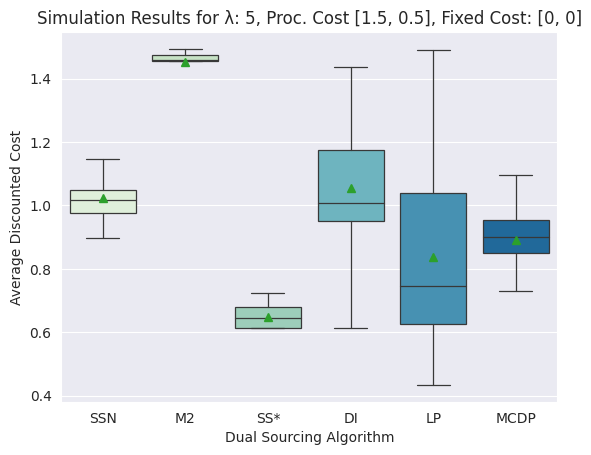

In [88]:
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(costs_array_labeled, columns =['Algorithm', 'Cost']) 

title_str = "Simulation Results for λ: %s, Proc. Cost %s, Fixed Cost: %s" % (str(model_params['mdp_env_params']['lambda']), str(model_params['mdp_env_params']['procurement_cost_vec']), str(model_params['mdp_env_params']['fixed_costs']))

sns.set_style("darkgrid")

meanprops={"marker":"_",
            "markerfacecolor":"white", 
            "markeredgecolor":"black",
            "markersize":"48"
        }

ax = sns.boxplot(x=df["Algorithm"], y=df["Cost"], width=0.8, showfliers=False, showmeans=True, linewidth = 0.9, palette = 'GnBu').set(
    xlabel='Dual Sourcing Algorithm', 
    ylabel='Average Discounted Cost',
    title = title_str)

file_id_prefix = file_id.split(".pkl")[0]
plt.savefig("results/summary_boxplot_" + file_id_prefix + '.png')

plt.show()

# https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

In [89]:
results_df = df.groupby('Algorithm').agg('mean')

In [90]:
results_df

,Cost
Algorithm,
DI,1.055579
LP,0.837110
M2,1.454160
MCDP,0.891965
SS*,0.648104
SSN,1.023221


In [91]:
file_id

'msource_value_dic_12-23-2022-06-42-13.pkl'

In [92]:
model_params['mdp_env_params']

{'lambda': 5,
 'max_inven': 30,
 'action_size': 40,
 'discount_fac': 1.0,
 'procurement_cost_vec': [1.5, 0.5],
 'supplier_lead_times_vec': [0.019, 0.4],
 'on_times': [1, 1],
 'off_times': 'no_disrup',
 'fixed_costs': [0, 0]}

In [93]:
result_output_dic = {}
result_output_dic["model_params"] = model_params
result_output_dic["results_df"] = results_df

write_path = "results/summary_obj_" + file_id 
with open(write_path, 'wb') as handle:
    pickle.dump(result_output_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [100]:
result_id = "msource_value_dic_12-27-2022-19-56-11.pkl"
filename = "results/summary_obj_" + result_id

with open(filename, 'rb') as f:
    result_obj = pkl.load(f)

result_obj["results_df"]

,Cost
Algorithm,
DI,0.746896
LP,0.789432
M2,1.007899
MCDP,0.961983
SS*,0.752104
SSN,1.008661


In [102]:
costs_array_labeled

[['SSN', 1.0247894256775898],
 ['SSN', 1.3663756029084235],
 ['SSN', 0.9741478327295229],
 ['SSN', 0.9782673785562085],
 ['SSN', 1.0062500128295553],
 ['SSN', 1.0133686658811314],
 ['SSN', 1.0347130365146544],
 ['SSN', 1.064125038663094],
 ['SSN', 1.033765757024789],
 ['SSN', 1.0431271639045545],
 ['SSN', 1.0743160286705082],
 ['SSN', 0.9511231482132713],
 ['SSN', 1.143580613474145],
 ['SSN', 1.0189172425554383],
 ['SSN', 1.0450507530680166],
 ['SSN', 0.9445886511363251],
 ['SSN', 1.0183887195859633],
 ['SSN', 1.005521538090938],
 ['SSN', 0.9550314955829945],
 ['SSN', 0.9821526366210631],
 ['SSN', 1.1446626892974086],
 ['SSN', 1.058566892480252],
 ['SSN', 1.0189172425554383],
 ['SSN', 0.8973072851035082],
 ['SSN', 0.9626536880817002],
 ['SSN', 1.064125038663094],
 ['SSN', 1.0031435438336227],
 ['SSN', 0.9895937021721168],
 ['SSN', 0.9989342723149867],
 ['SSN', 0.965009492858952],
 ['SSN', 0.9650326065329897],
 ['SSN', 1.0629750392043171],
 ['SSN', 1.026392003482791],
 ['SSN', 1.0169738

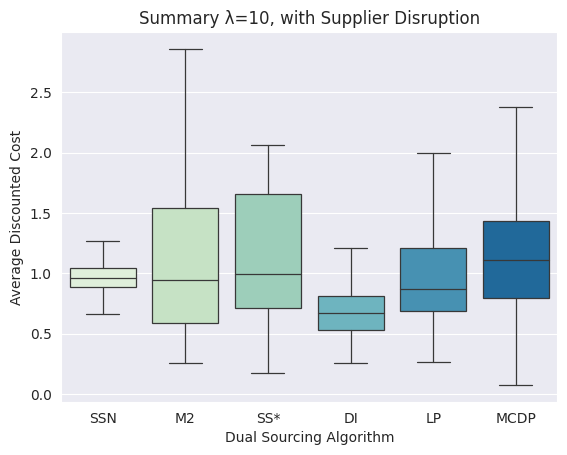

In [143]:
summary_id = "sumf_lam_10_dis_allcosts_v2.pkl"
filename = "results/" + summary_id

with open(filename, 'rb') as f:
    summary_list = pkl.load(f)


df = pd.DataFrame(summary_list, columns =['Algorithm', 'Cost']) 

title_str = "Summary λ=10, with Supplier Disruption"

sns.set_style("darkgrid")

meanprops={"marker":"_",
            "markerfacecolor":"white", 
            "markeredgecolor":"black",
            "markersize":"48"
        }

ax = sns.boxplot(x=df["Algorithm"], y=df["Cost"], width=0.8, showfliers=False, linewidth = 0.9, palette = 'GnBu').set(
    xlabel='Dual Sourcing Algorithm', 
    ylabel='Average Discounted Cost',
    title = title_str)

file_id_prefix = file_id.split(".pkl")[0]
plt.savefig("results/summary_boxplot_" + file_id_prefix + '.png')

plt.show()

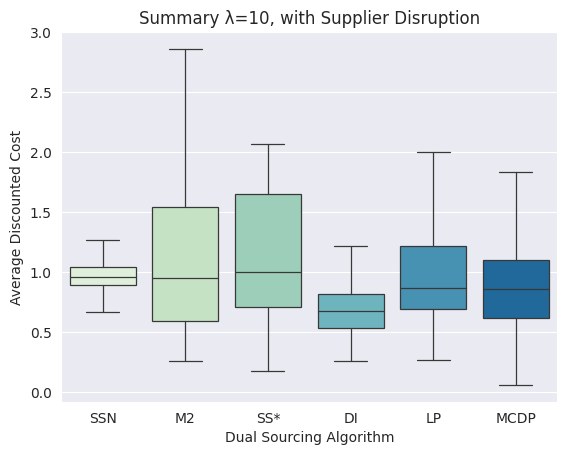

In [145]:
summary_list_ = summary_list

df = pd.DataFrame(summary_list_, columns =['Algorithm', 'Cost']) 

sns.set_style("darkgrid")

ax = sns.boxplot(x=df["Algorithm"], y=df["Cost"], width=0.8, showfliers=False, linewidth = 0.9, palette = 'GnBu').set(
    xlabel='Dual Sourcing Algorithm', 
    ylabel='Average Discounted Cost',
    title = title_str)

In [ ]:
file_id_prefix = file_id.split(".pkl")[0]
plt.savefig("results/summary_boxplot_" + file_id_prefix + '.png')

plt.show()